In [18]:
library(tidyverse)
library(readxl)
library(geofacet)

options(repr.plot.width = 16, repr.plot.height = 9, repr.plot.res = 240,
        readr.show_col_types = F)

colors = c("#8c0900", "#28e6ff", "#ff492a", "#b4b7bd")

theme_set(theme_minimal())

In [2]:
download.file("https://cdn.who.int/media/docs/default-source/world-health-data-platform/covid-19-excessmortality/2022-03-25_covid-19_gem.zip?sfvrsn=2d5835e0_2",
             destfile = "2022-03-25_covid-19_gem.zip")

In [37]:
df_rate <- read_excel(unzip("2022-03-25_covid-19_gem.zip", "WHO_COVID_Excess_Deaths_EstimatesByCountry.xlsx"),
                  sheet = "Country rate by year", skip = 8)


In [42]:
df_pop <- 
  df_rate%>%
  filter(year=="2020-2021")%>%
  select(iso3, pop.e5)

In [140]:
data <- read_excel(unzip("2022-03-25_covid-19_gem.zip", "WHO_COVID_Excess_Deaths_EstimatesByCountry.xlsx"),
                  sheet = "Country by year and month", skip = 12)%>%
  mutate(Date = as.Date(paste0(year, "-", str_pad(month, 2, pad = "0"), "-15")))%>%
  merge(df_pop)

data <-
  data%>%
  merge(data%>%
          group_by(iso3)%>%
          summarise(baseline.mean = mean(expected.mean)))
head(data)
# Predicted / Reported

,iso3,country,year,month,type,expected.mean,acm.mean,excess.mean,cumul.excess.mean,cumul.excess.low,cumul.excess.high,Date,pop.e5,baseline.mean
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>
1,AFG,Afghanistan,2020,1,Predicted,23143,24439,1296,1296,-4377,7871,2020-01-15,393.8188,21313.58
2,AFG,Afghanistan,2020,2,Predicted,22452,22989,537,1833,-6626,10834,2020-02-15,393.8188,21313.58
3,AFG,Afghanistan,2020,9,Predicted,20509,21721,1213,8387,-8830,25119,2020-09-15,393.8188,21313.58
4,AFG,Afghanistan,2020,10,Predicted,21386,23935,2549,10936,-6874,28958,2020-10-15,393.8188,21313.58
5,AFG,Afghanistan,2020,11,Predicted,22286,26847,4561,15498,-4236,35380,2020-11-15,393.8188,21313.58
6,AFG,Afghanistan,2020,12,Predicted,23037,26932,3895,19392,-1297,40224,2020-12-15,393.8188,21313.58


In [143]:
# 1. Made your dictionnary

dictio_replace= c(
    "Democratic People's Republic of Korea" = "Korea",
    "Venezuela (Bolivarian Republic of)" = "Venezuela",
    "Bolivia (Plurinational State of)"= "Bolivia",
    "Saint Vincent and the Grenadines"= "Saint Vincent",
    "Democratic Republic of the Congo"= "DRC",
    "Lao People's Democratic Republic"= "Laos ",
    "Micronesia (Federated States of)"= "Micronesia",
    "United Republic of Tanzania"= "Tanzania",
    "Iran (Islamic Republic of)"= "Iran",
    "United States of America"= "USA",
    "Central African Republic"= "CAR",
    "Bosnia and Herzegovina"= "Bosnia",
    "Sao Tome and Principe"= "Sao Tome",
    "Saint Kitts and Nevis"= "Saint Kitts",
    "Syrian Arab Republic"= "Syria",
    "United Arab Emirates"= "UAE",
    "Republic of Moldova"= "Moldova",
    "Trinidad and Tobago"= "T & T",
    "Antigua and Barbuda"= "Antigua",
    "Russian Federation"= "Russia",
    "The United Kingdom"= "UK",
    "Dominican Republic"= "Dom. Rep.")

# 2. Replace all pattern, according to the dictionary-values (only a single vector of string, or a single string)
data$country <- stringr::str_replace_all(string = data$country,
                                      pattern= fixed(dictio_replace))

#data%>%filter(iso3 =="BOL")

In [142]:
dummy =  
  (data%>%
  group_by(country, iso3)%>% 
  arrange(Date)%>%
  summarise(cumul.excess = last(cumul.excess.mean/pop.e5))%>%
  arrange(desc(cumul.excess)))
countries_by_deaths = dummy$country

#dummy%>%mutate(len = nchar(country))%>%arrange(desc(len))

`summarise()` has grouped output by 'country'. You can override using the
`.groups` argument.


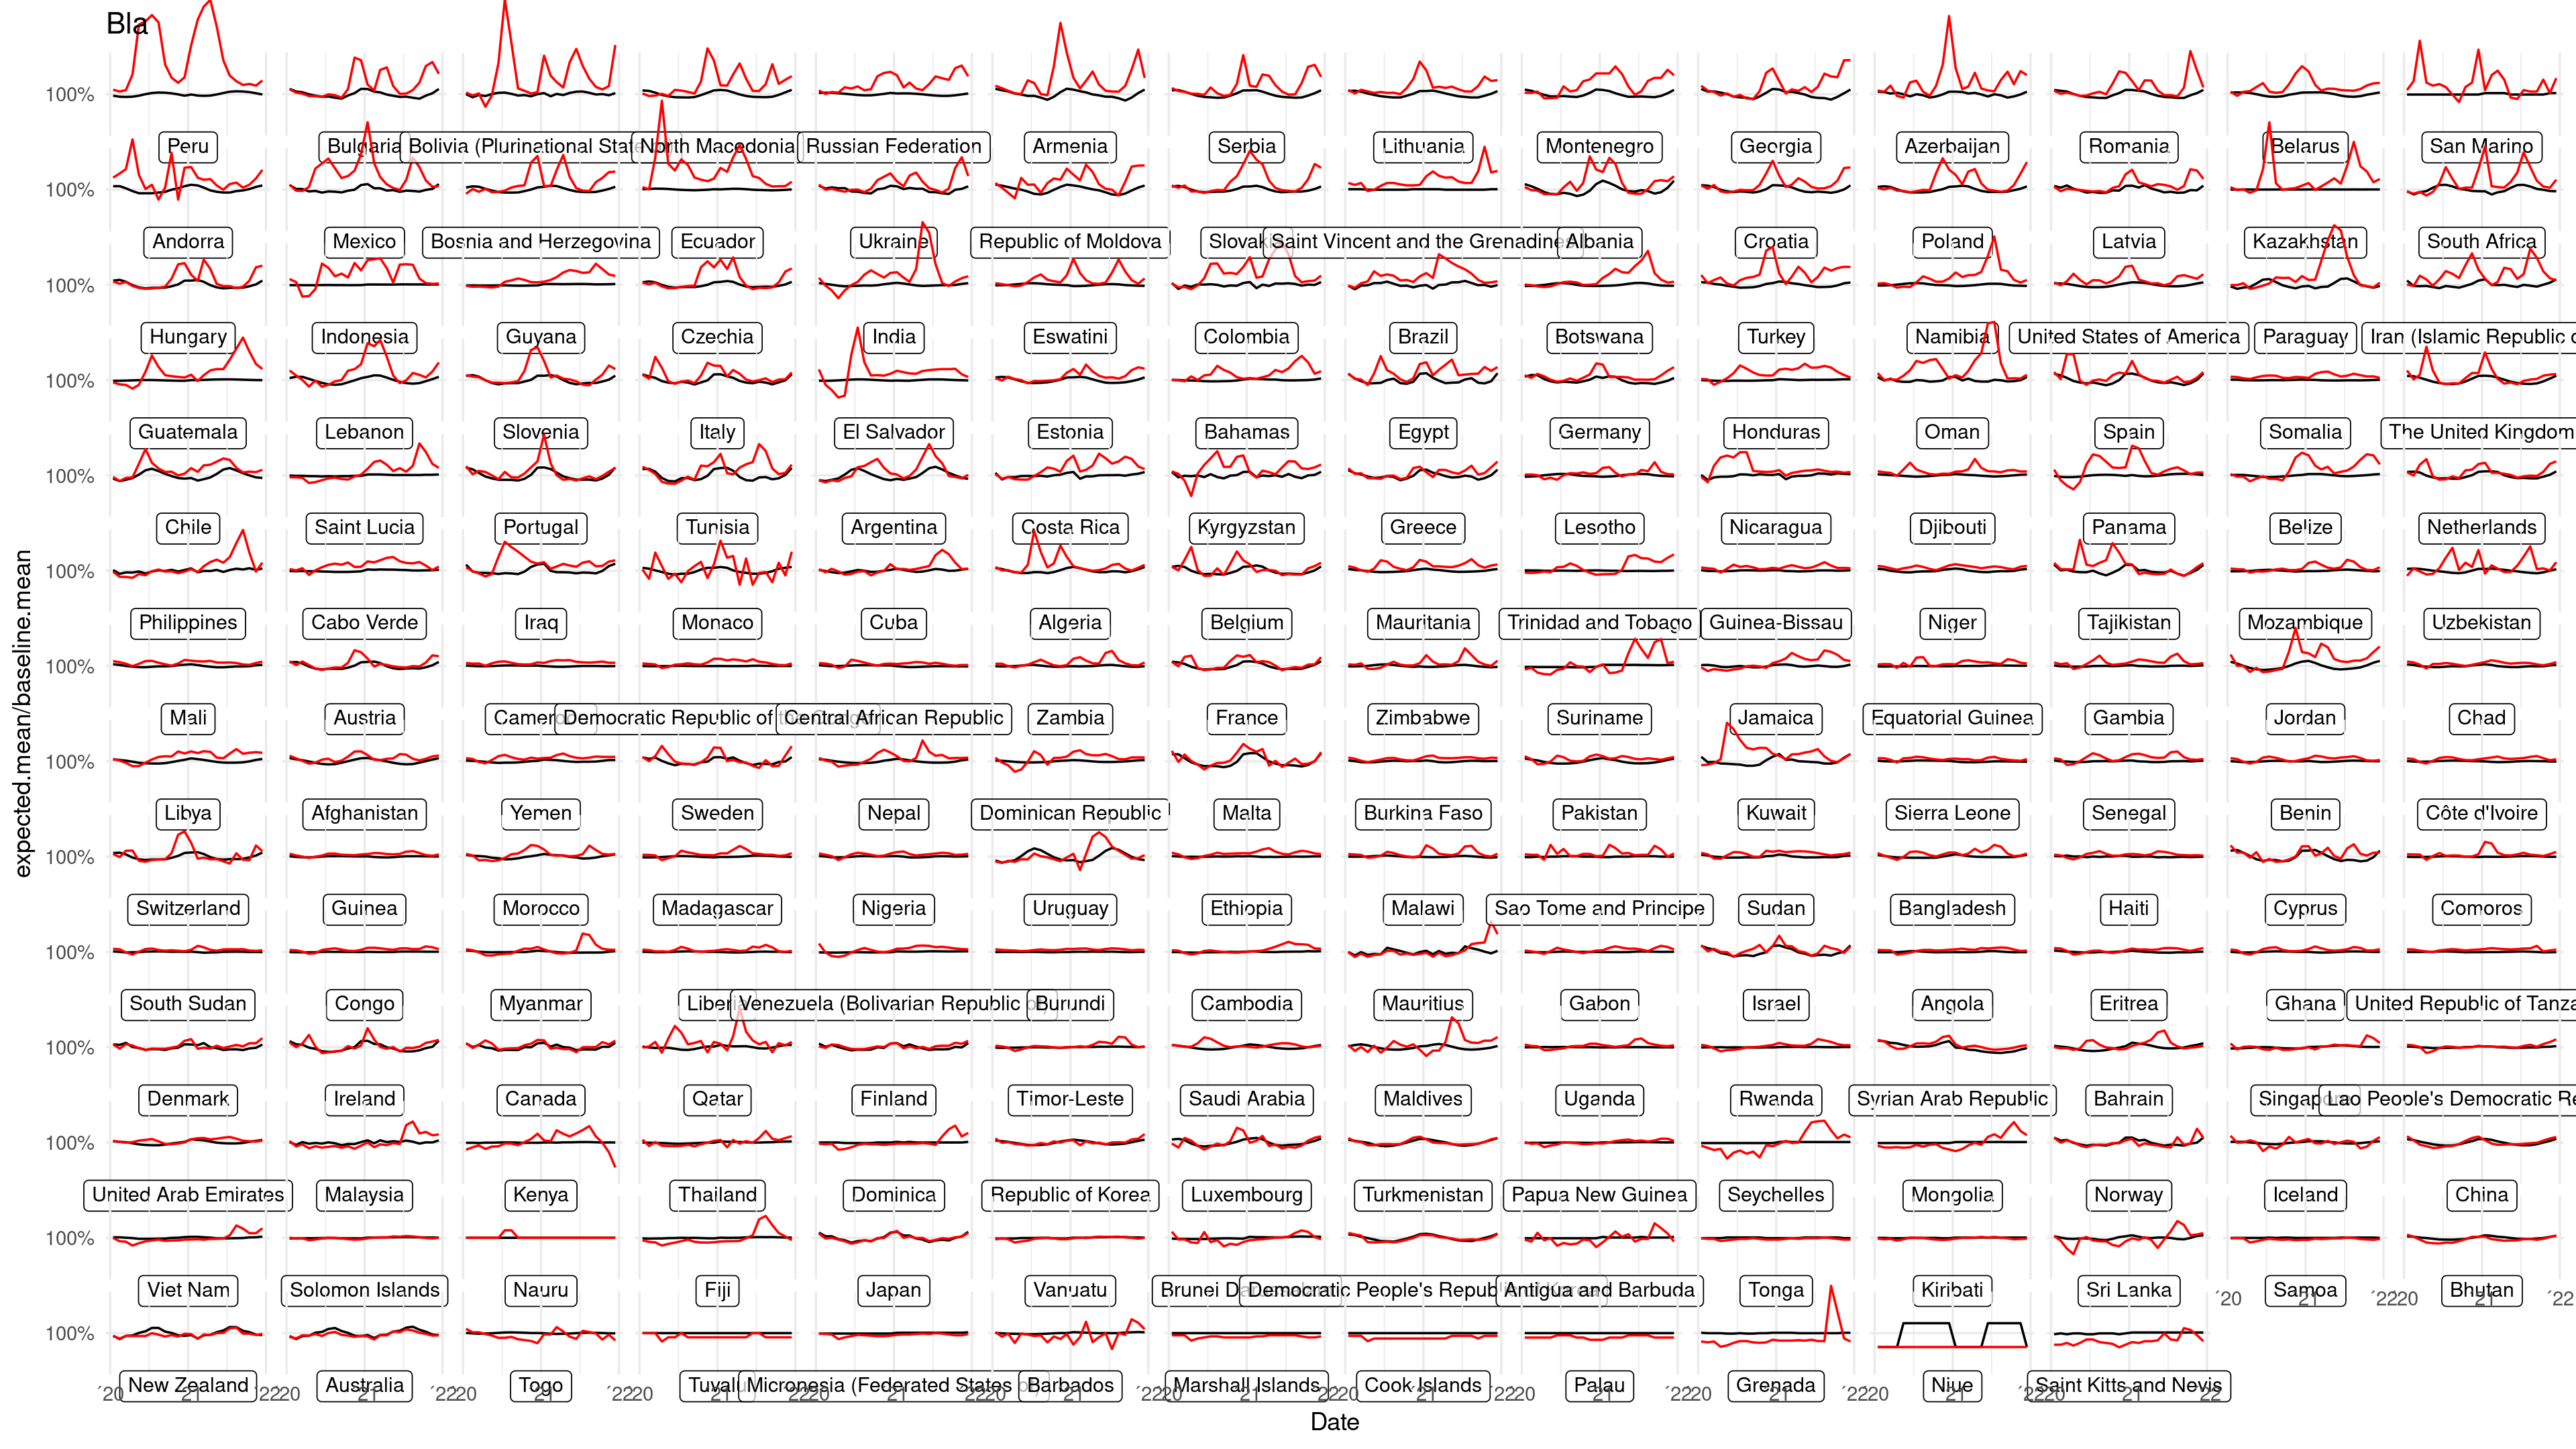

In [86]:
# denominators: pop.e5, baseline.mean
data%>%
  ggplot(aes(x = Date, y = `expected.mean`/baseline.mean)) +
  labs(title =  "Bla") +
  geom_line() +
  geom_line(aes(y = `acm.mean`/baseline.mean), color = "red") +
  coord_cartesian(ylim = c(0, 2), clip = "off") +
  scale_x_date(date_labels = "´%y", date_breaks = "1 year") +
  scale_y_continuous(labels = scales::percent, breaks = c(1)) +
  facet_wrap(~factor(country, levels = countries_by_deaths)) +  
  geom_label(data = dummy, 
             aes(label = country), 
             alpha = 0.7, x = as.Date("2021-01-01"),
             y = 0, size = 3.2, vjust = 1) +
  theme(#axis.text.y=element_blank(),
        strip.text.x = element_blank(),
        axis.ticks.y=element_blank())

In [145]:
library(geofacet)
#get_grid_names()

Note: You provided a user-specified grid. If this is a generally-useful
  grid, please consider submitting it to become a part of the geofacet
  package. You can do this easily by calling:
  grid_submit(__grid_df_name__)

Some values in the specified facet_geo column 'iso3' do not match the
  'code_alpha3' column of the specified grid and will be removed: AND,
  COK, MCO, NIU, SMR



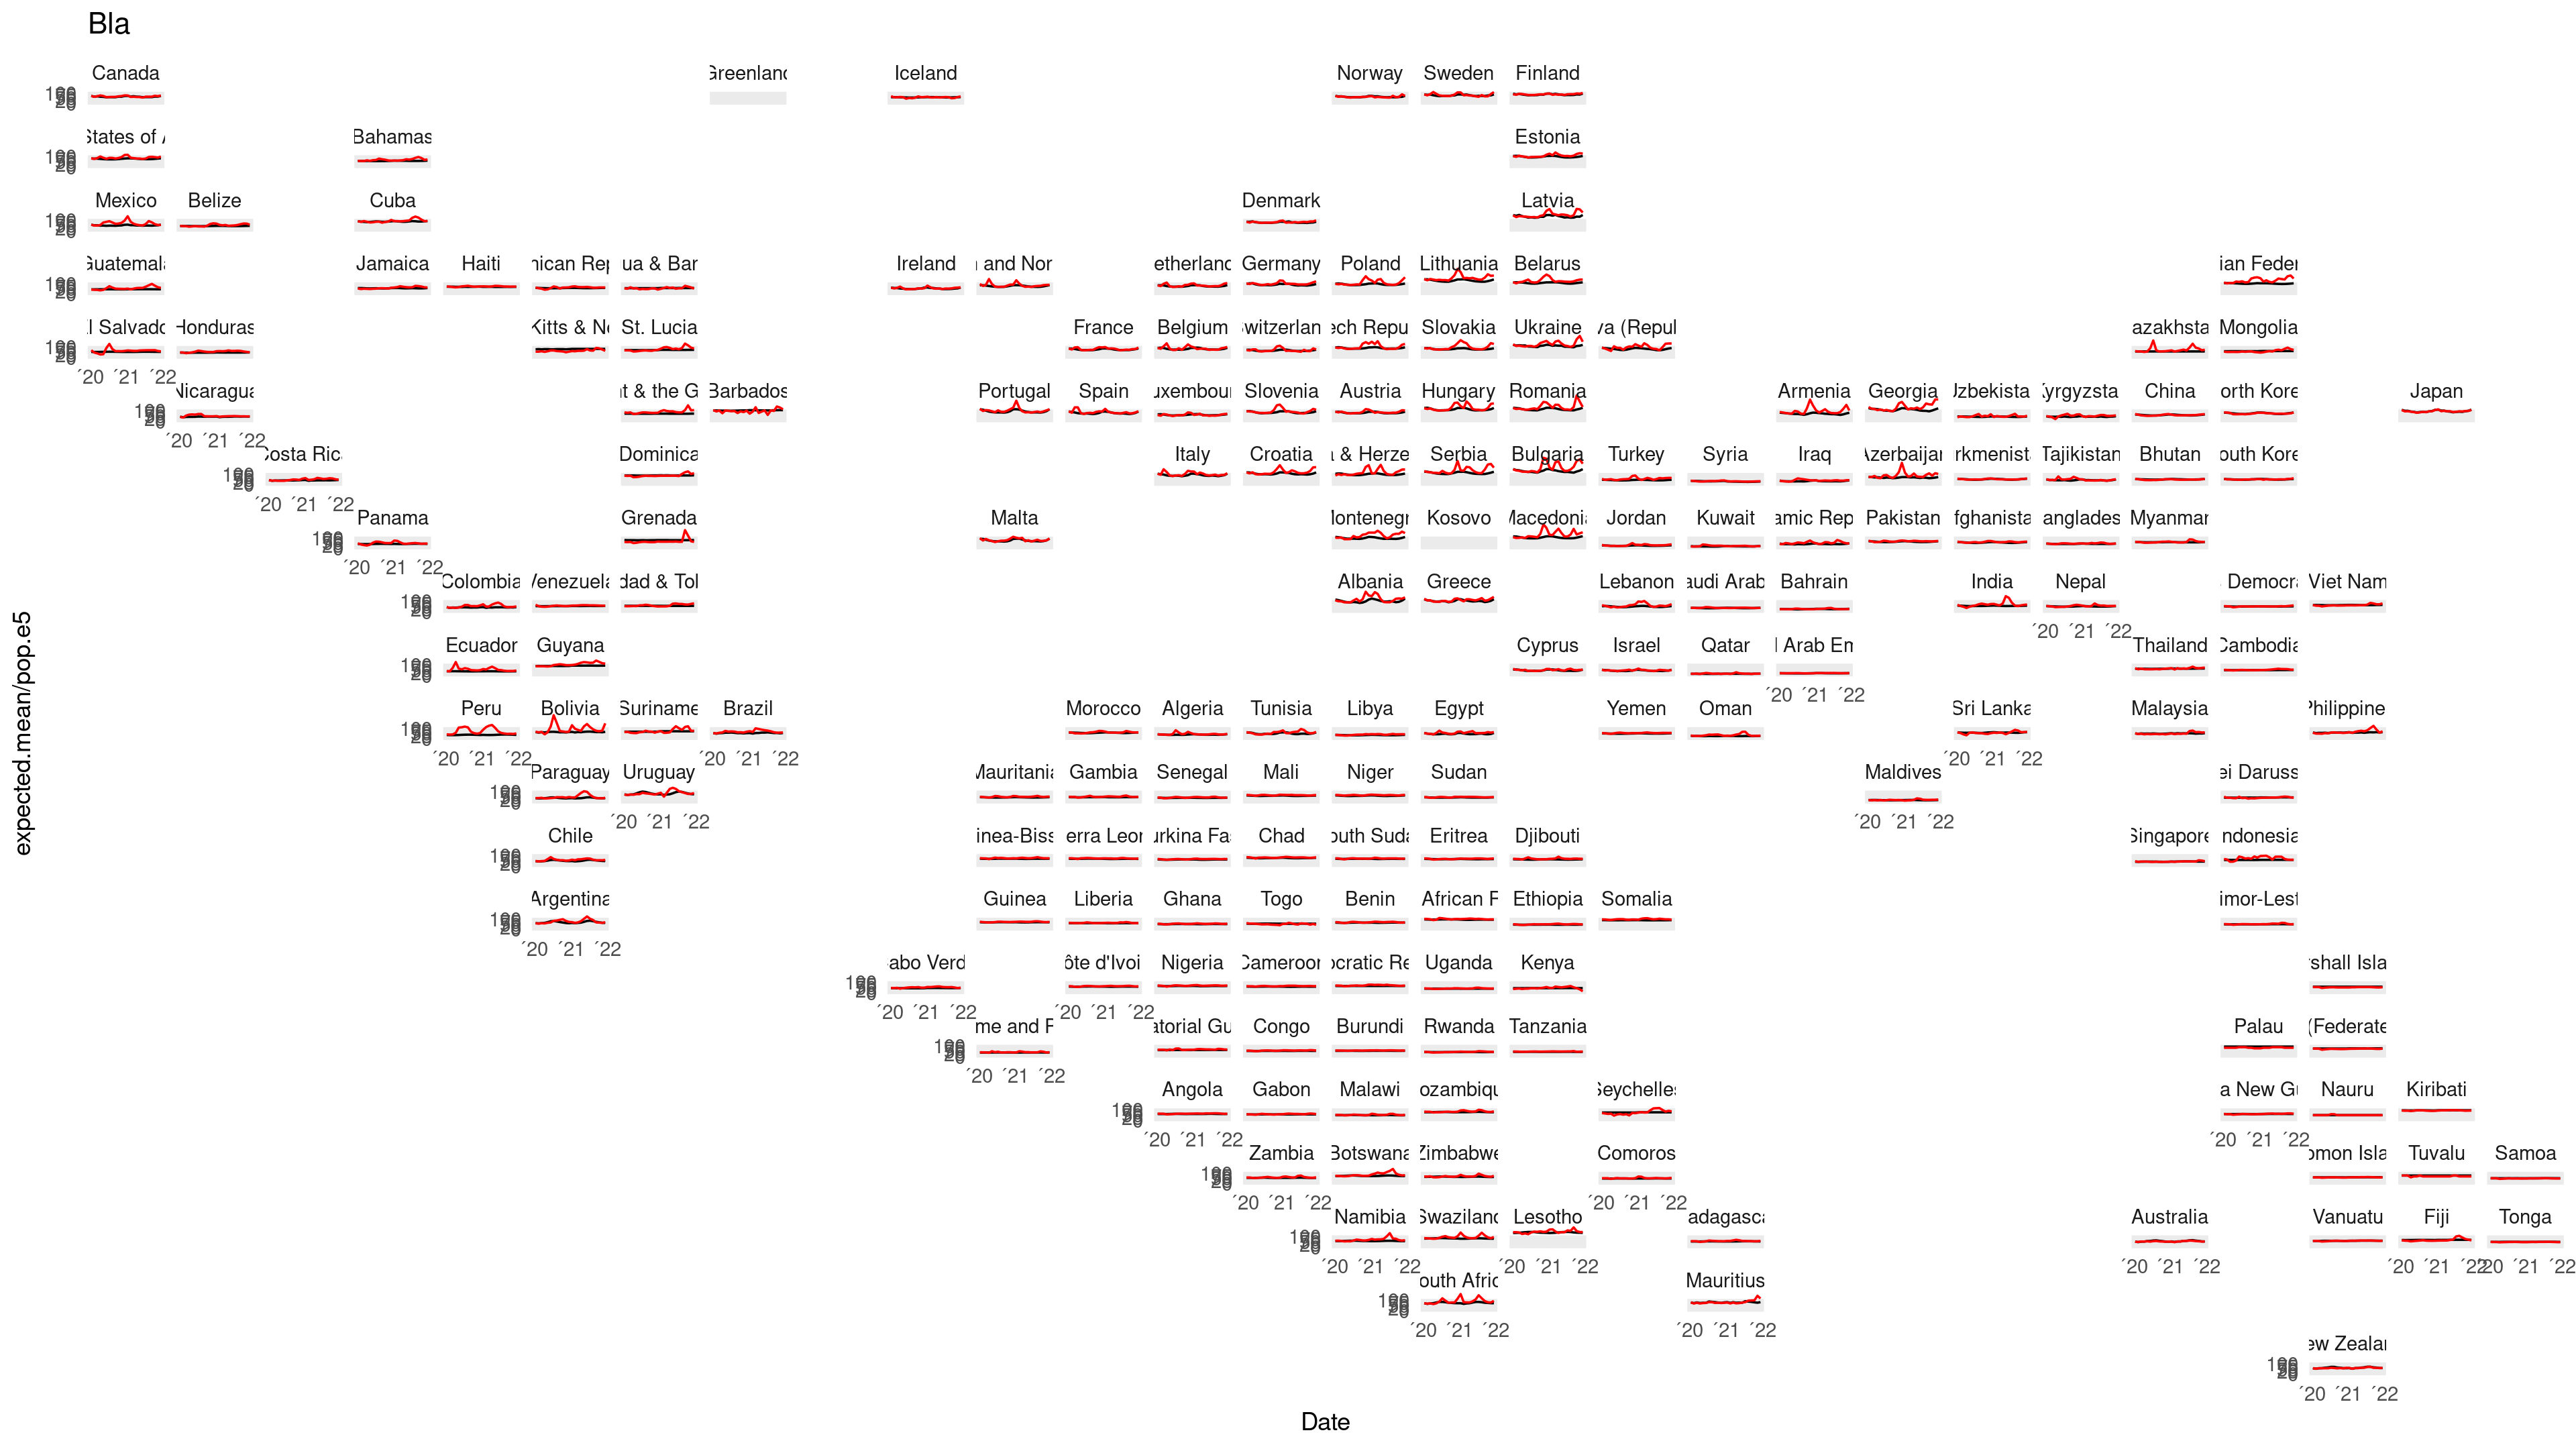

In [146]:
data%>%
  #filter(type != "Predicted") %>% 
  ggplot(aes(x = Date, y = `expected.mean`/pop.e5)) +
  labs(title =  "Bla") +
  geom_line() +
  geom_line(aes(y = `acm.mean`/pop.e5), color = "red") +
  scale_y_continuous(limits = c(0, NA)) +
  coord_cartesian(ylim = c(0, 100), clip = "off") +
  scale_x_date(date_labels = "´%y", date_breaks = "1 year") +
#  facet_wrap(~country, scale = "free_y") +
#  scale_linetype_manual(values = c("solid", "dashed")) +
  theme(#axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
  #facet_geo(~iso3, grid = "world_86countries_grid")
  facet_geo(~iso3, grid = world_countries_grid1%>%filter(name!="Antarctica"), label = "name")


Note: You provided a user-specified grid. If this is a generally-useful
  grid, please consider submitting it to become a part of the geofacet
  package. You can do this easily by calling:
  grid_submit(__grid_df_name__)

Some values in the specified facet_geo column 'iso3' do not match the
  'code_alpha3' column of the specified grid and will be removed: AND,
  COK, MCO, NIU, SMR



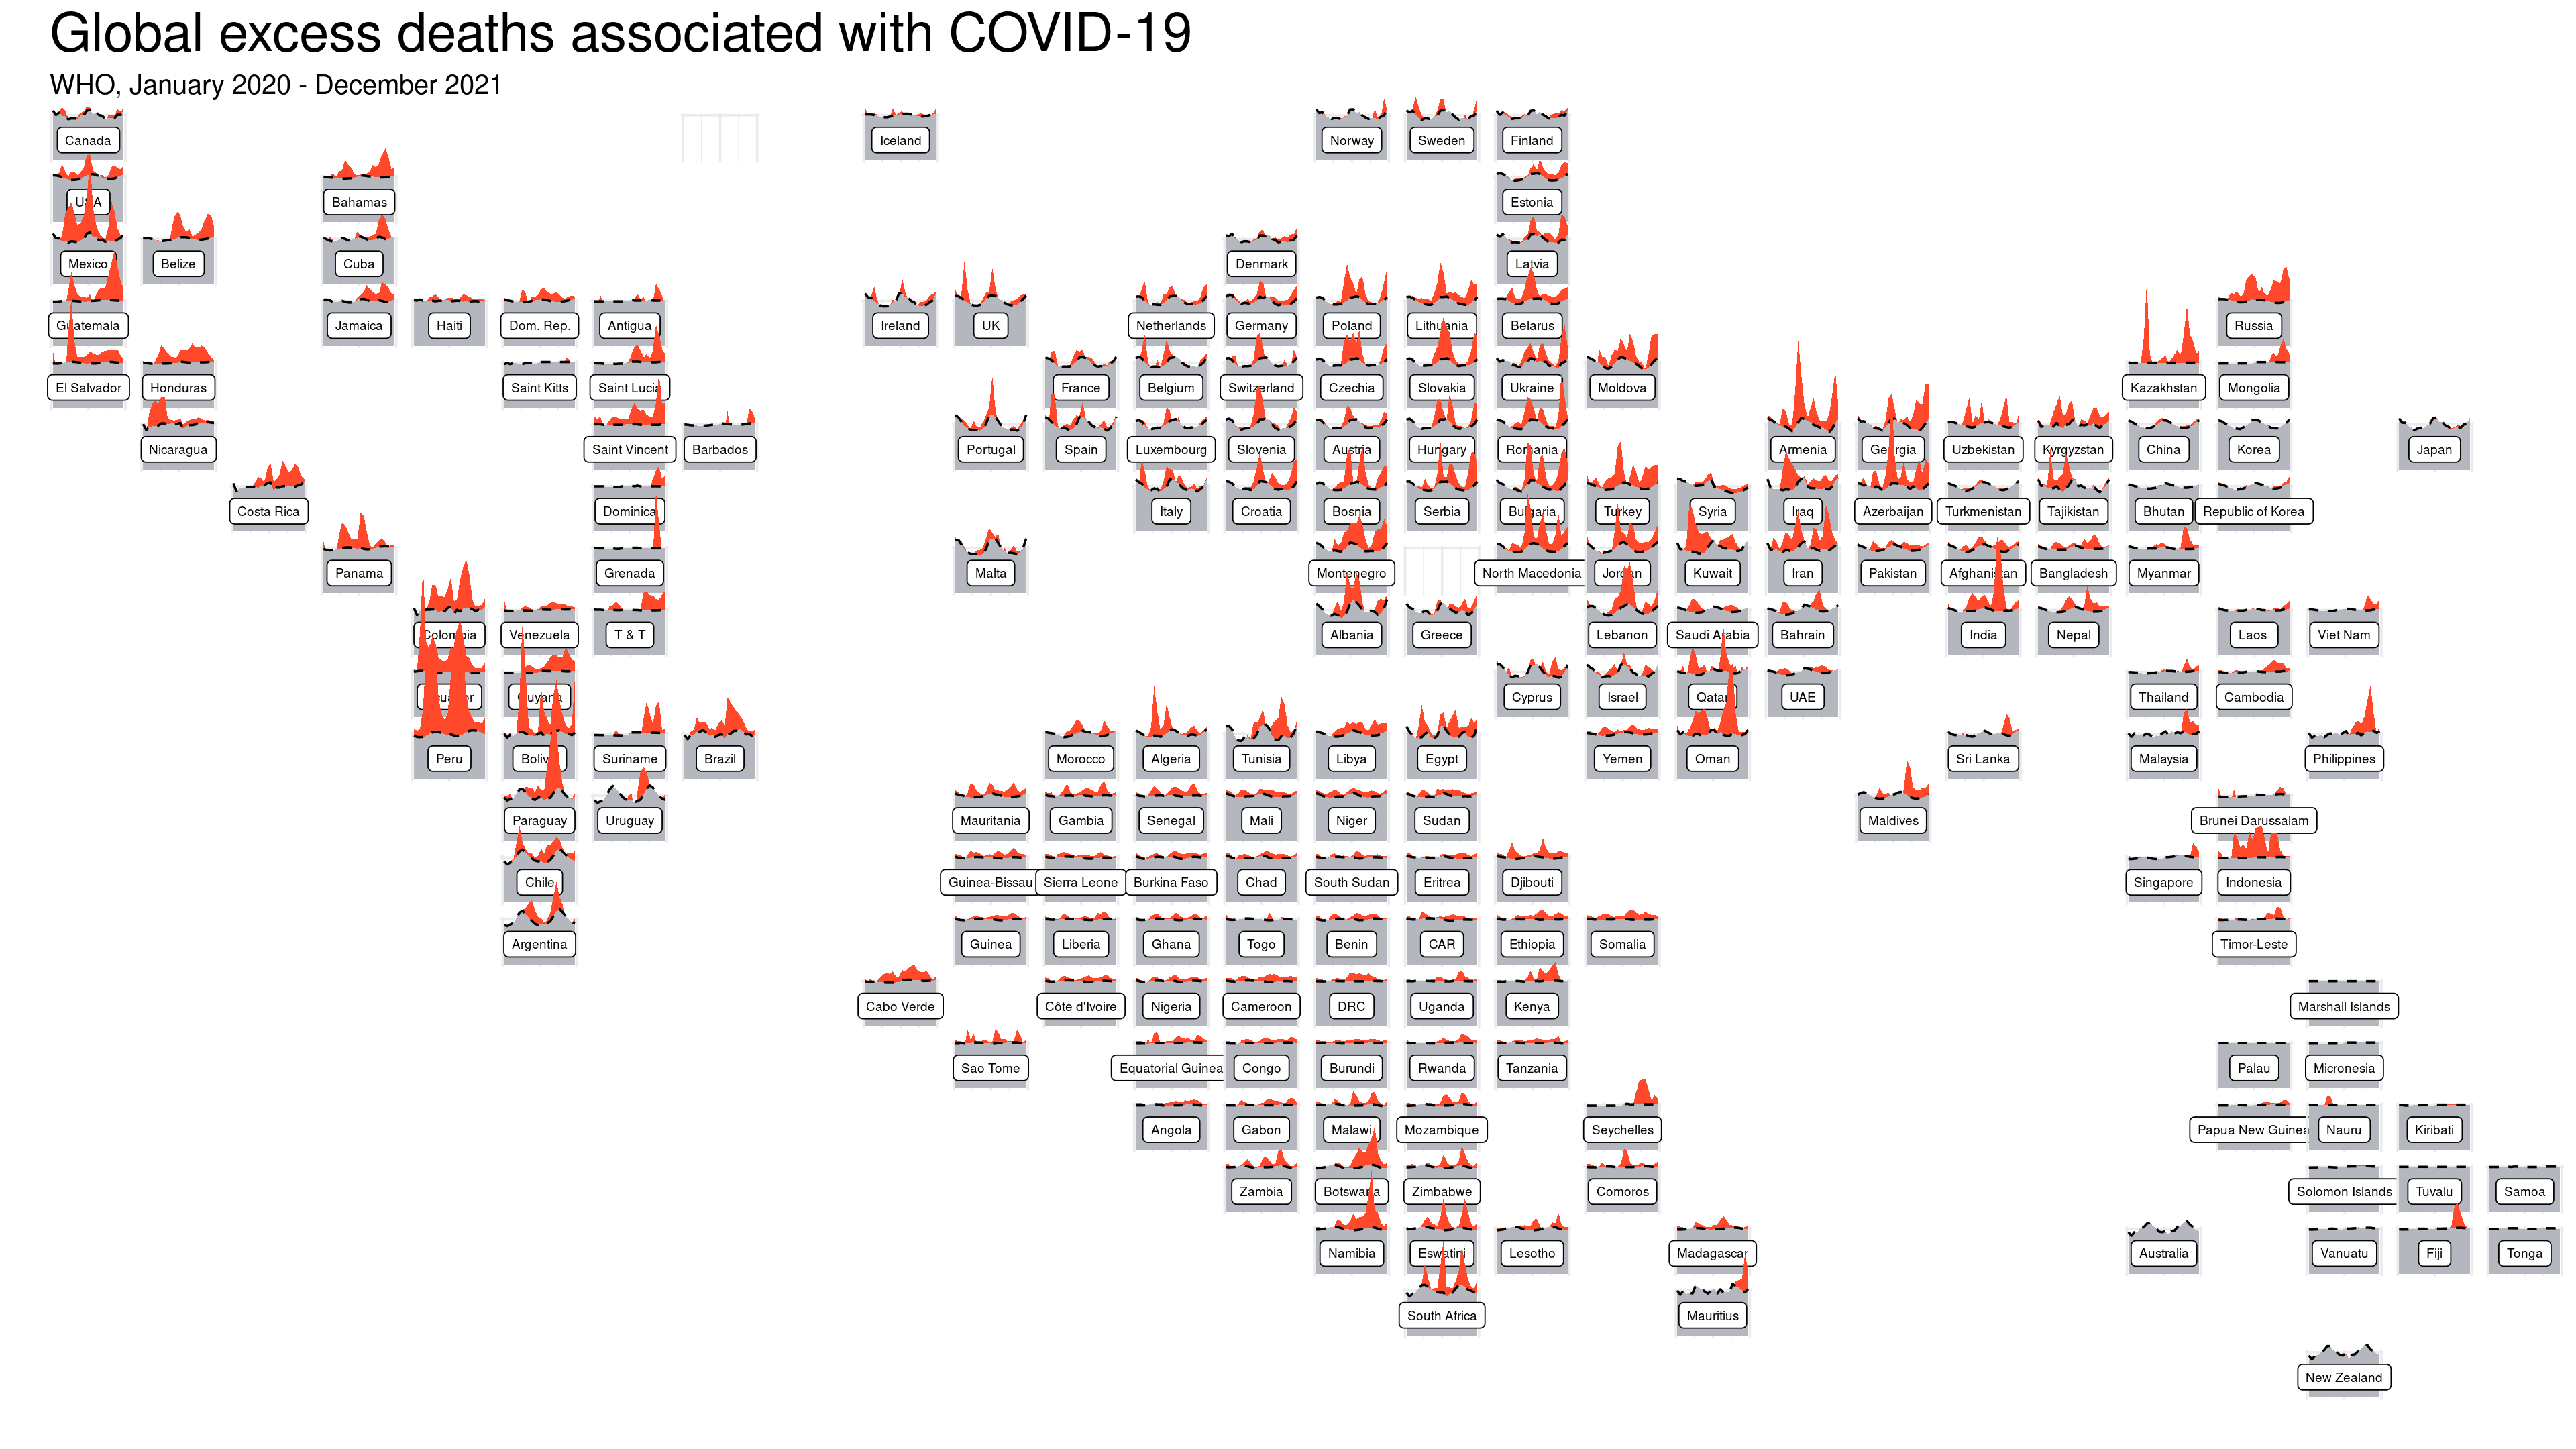

In [157]:
data%>%
  ggplot(aes(x = Date, y = `expected.mean`/baseline.mean)) +
  labs(title =  "Global excess deaths associated with COVID-19",
       subtitle = "WHO, January 2020 - December 2021", x = "", y = "") +
  geom_area(aes(y = `acm.mean`/baseline.mean), fill = "#ff492a") +
  geom_area(fill = "#b4b7bd") +
  geom_line(linetype = 2) +
  coord_cartesian(ylim = c(0, 1), clip = "off") +
  scale_x_date(date_labels = "´%y", date_breaks = "1 year") +
  scale_y_continuous(labels = scales::percent, breaks = c(1)) +
  geom_label(data = dummy%>%filter(iso3 %in% world_countries_grid1$code_alpha3), 
             aes(label = country), 
             alpha = 1, x = as.Date("2021-01-01"),
             y = .45, size = 2) +
  theme(plot.title=element_text( size = 24),
        plot.subtitle=element_text(size = 12),
        strip.text.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()) +
  facet_geo(~iso3, grid = world_countries_grid1%>%filter(name!="Antarctica"))#, label = "name")